In [1]:
# import required libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from bs4 import BeautifulSoup
import requests
import pandas as pd
import constants
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [2]:
def get_hot100():
    top100_url = 'https://top40weekly.com/top-100-songs-of-all-time/'
    source = requests.get(top100_url).text
    soup = BeautifulSoup(source, 'lxml')
    song_list = soup.findAll('div', class_='x-text song-title')
    artists = soup.findAll('div', class_='x-text artist-name')
    release_years = soup.findAll('div', class_='x-text song-rel')

    def scrape_text(html_code):
        return html_code.text.strip()

    def scrape_int(html_code):
        return int(scrape_text(html_code)[-4:])

    song_list = list(map(scrape_text, song_list))
    artists = list(map(scrape_text, artists))
    release_years = list(map(scrape_int, release_years))
    hot100_df = pd.DataFrame({'songs':song_list, 'artists':artists, 'release_years': release_years})
    hot100_df.head()
    hot100_df['songs'] = hot100_df['songs'].apply(str.capitalize)
    hot100_df['artists'] = hot100_df['artists'].apply(str.capitalize)
    
    return hot100_df

In [3]:
hot100df = get_hot100()
hot100df.head()

,songs,artists,release_years
0,The twist,Chubby checker,1960
1,Smooth,Santana feat. rob thomas,1999
2,Mack the knife,Bobby darin,1959
3,Uptown funk!,Mark ronson feat. bruno mars,2015
4,How do i live,Leann rimes,1997


In [4]:
def connect_to_api():
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= constants.client_id,
                                                           client_secret= constants.client_secret))
    return sp

In [5]:
playlist_ids = constants.playlist_ids

In [6]:
def get_playlist_tracks(username,playlist_id):
    '''Gets playlist\'s all tracks according to playlist id.'''
    sp = connect_to_api()
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [7]:
# creates dataframe, according to given playlist_id
# helper function
def create_df_from_playlist(playlist_id):
    sp = connect_to_api()
    song_list = list()
    lst = get_playlist_tracks('spotify', playlist_id)
    try:
        for i in range(len(lst)):
            song_list.append(sp.audio_features(lst[i]['track']['id'])[0])
    except:
        pass
    return pd.DataFrame(song_list)

In [8]:
# creates dataframe, according to given playlist_id list


def create_songs_df(playlist_ids):
    songs = pd.DataFrame()
    for i in playlist_ids:
        try:
            new = create_df_from_playlist(i)
            songs = pd.concat([songs, new], ignore_index=True)
        except:
            pass
    return songs

In [9]:
songs_df = create_songs_df(playlist_ids)

print(len(songs_df))
print('\n'*5)
songs_df.head(10)

3685








,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.788,0.859,2,-2.724,1,0.0856,0.281000,0.000000,0.0424,0.822,141.020,audio_features,6bQfNiqyCX7UaQSvVVGo4I,spotify:track:6bQfNiqyCX7UaQSvVVGo4I,https://api.spotify.com/v1/tracks/6bQfNiqyCX7U...,https://api.spotify.com/v1/audio-analysis/6bQf...,207853,4
1,0.787,0.833,8,-4.403,1,0.0478,0.018000,0.007470,0.0374,0.796,123.970,audio_features,6Dy1jexKYriXAVG6evyUTJ,spotify:track:6Dy1jexKYriXAVG6evyUTJ,https://api.spotify.com/v1/tracks/6Dy1jexKYriX...,https://api.spotify.com/v1/audio-analysis/6Dy1...,162604,4
2,0.591,0.764,1,-5.484,1,0.0483,0.038300,0.000000,0.1030,0.478,169.928,audio_features,5HCyWlXZPP0y6Gqq8TgA20,spotify:track:5HCyWlXZPP0y6Gqq8TgA20,https://api.spotify.com/v1/tracks/5HCyWlXZPP0y...,https://api.spotify.com/v1/audio-analysis/5HCy...,141806,4
3,0.767,0.438,7,-8.726,0,0.2900,0.181000,0.000000,0.1420,0.381,86.975,audio_features,37Nqx7iavZpotJSDXZWbJ3,spotify:track:37Nqx7iavZpotJSDXZWbJ3,https://api.spotify.com/v1/tracks/37Nqx7iavZpo...,https://api.spotify.com/v1/audio-analysis/37Nq...,221980,4
4,0.612,0.862,8,-2.903,1,0.0370,0.041000,0.000000,0.0907,0.354,123.849,audio_features,4laAKIq9ZxBCwf99rauPYb,spotify:track:4laAKIq9ZxBCwf99rauPYb,https://api.spotify.com/v1/tracks/4laAKIq9ZxBC...,https://api.spotify.com/v1/audio-analysis/4laA...,160766,4
5,0.812,0.634,8,-4.960,1,0.1630,0.056400,0.000000,0.2760,0.463,124.074,audio_features,7zx1i0jGcFwMBurajgKlO7,spotify:track:7zx1i0jGcFwMBurajgKlO7,https://api.spotify.com/v1/tracks/7zx1i0jGcFwM...,https://api.spotify.com/v1/audio-analysis/7zx1...,174194,4
6,0.638,0.878,5,-3.639,0,0.0484,0.015100,0.000223,0.3080,0.481,103.948,audio_features,0MWiSBKm8Avs8iDIxcertp,spotify:track:0MWiSBKm8Avs8iDIxcertp,https://api.spotify.com/v1/tracks/0MWiSBKm8Avs...,https://api.spotify.com/v1/audio-analysis/0MWi...,176800,4
7,0.814,0.874,6,-5.316,1,0.0425,0.000222,0.522000,0.2760,0.434,123.992,audio_features,1olCzMxaeiQKNO64ssWVGr,spotify:track:1olCzMxaeiQKNO64ssWVGr,https://api.spotify.com/v1/tracks/1olCzMxaeiQK...,https://api.spotify.com/v1/audio-analysis/1olC...,161041,4
8,0.587,0.561,0,-6.569,1,0.1460,0.046600,0.000000,0.1090,0.351,80.009,audio_features,0RbW8kWozrVSIGb4V13o0o,spotify:track:0RbW8kWozrVSIGb4V13o0o,https://api.spotify.com/v1/tracks/0RbW8kWozrVS...,https://api.spotify.com/v1/audio-analysis/0RbW...,243187,4
9,0.695,0.781,7,-5.578,0,0.0452,0.018500,0.000031,0.2950,0.456,124.040,audio_features,4xMbBESczlHPUO8QeYi56p,spotify:track:4xMbBESczlHPUO8QeYi56p,https://api.spotify.com/v1/tracks/4xMbBESczlHP...,https://api.spotify.com/v1/audio-analysis/4xMb...,148960,4


In [12]:
songs_df.drop_duplicates(subset =None,
                     keep = False, inplace = True)

In [13]:
len(songs_df)

3009

In [14]:
songs_df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [15]:
X = songs_df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url'], axis='columns')\
            .reset_index()\
            .drop('index', axis='columns')

In [16]:
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.806,0.513,4,-6.208,1,0.0685,0.21700,0.000000,0.2170,0.503,124.988,178157,4
1,0.356,0.684,8,-7.347,1,0.0878,0.15200,0.000000,0.1010,0.347,87.188,193733,4
2,0.750,0.608,1,-4.008,1,0.0387,0.00165,0.000000,0.1780,0.958,132.507,173347,4
3,0.749,0.569,7,-5.165,1,0.1890,0.50400,0.000000,0.0788,0.648,133.472,216014,5
4,0.722,0.844,3,-2.258,0,0.0910,0.08520,0.000082,0.1220,0.746,109.938,159668,4


In [17]:
standard_scaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(X)

standardized_df = pd.DataFrame(x_scaled, columns = X.columns)

standardized_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1.063008,0.170234,-0.212173,0.797050,0.719836,-0.149200,-0.600669,-0.886759,0.624141,0.185886,0.255332,-0.148421,0.263428
1,-1.189158,0.745228,0.893809,0.669977,0.719836,0.071956,-0.768930,-0.886759,-0.440900,-0.425763,-0.991305,0.123410,0.263428
2,0.782739,0.489675,-1.041660,1.042493,0.719836,-0.490674,-1.158130,-0.886759,0.266067,1.969862,0.503308,-0.232365,0.263428
3,0.777734,0.358536,0.617314,0.913412,0.719836,1.231592,0.142266,-0.886759,-0.644726,0.754406,0.535133,0.512257,2.280363
4,0.642604,1.283234,-0.488669,1.237733,-1.389206,0.108624,-0.941850,-0.886565,-0.248091,1.138647,-0.241014,-0.471091,0.263428


In [18]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 15)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(standardized_df)
    kmeanModel.fit(standardized_df)
 
    distortions.append(sum(np.min(cdist(standardized_df, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / standardized_df.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(standardized_df, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / standardized_df.shape[0]
    mapping2[k] = kmeanModel.inertia_

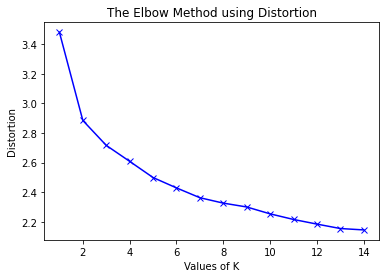

In [19]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

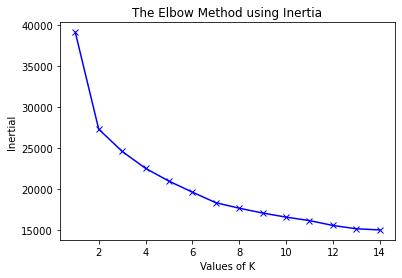

In [20]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertial')
plt.title('The Elbow Method using Inertia')
plt.show()

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

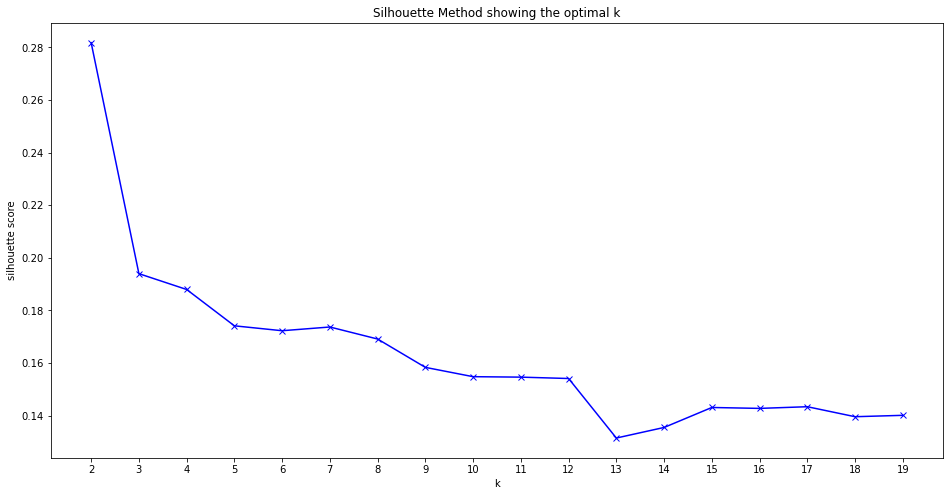

In [21]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(standardized_df)
    #filename = "Model/kmeans_" + str(k) + ".pickle"
    #with open(filename, "wb") as f:
        #pickle.dump(kmeans,f)
    silhouette.append(silhouette_score(standardized_df, kmeans.predict(standardized_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [22]:
k = 12

kmeans_model = KMeans(n_clusters=k, random_state=42).fit(standardized_df)

songs_df['clusters'] = X['clusters'] = kmeans_model.labels_

kmeans_model.labels_

array([2, 0, 8, ..., 9, 0, 0])

In [23]:
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,clusters
0,0.806,0.513,4,-6.208,1,0.0685,0.21700,0.000000,0.2170,0.503,124.988,178157,4,2
1,0.356,0.684,8,-7.347,1,0.0878,0.15200,0.000000,0.1010,0.347,87.188,193733,4,0
2,0.750,0.608,1,-4.008,1,0.0387,0.00165,0.000000,0.1780,0.958,132.507,173347,4,8
3,0.749,0.569,7,-5.165,1,0.1890,0.50400,0.000000,0.0788,0.648,133.472,216014,5,0
4,0.722,0.844,3,-2.258,0,0.0910,0.08520,0.000082,0.1220,0.746,109.938,159668,4,5


In [24]:
songs_df.tail()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,clusters
3677,0.666,0.603,1,-5.671,1,0.0763,0.49700,0.000000,0.1120,0.262,102.940,audio_features,2sfZgYusD8bBvB7qWekvSx,spotify:track:2sfZgYusD8bBvB7qWekvSx,https://api.spotify.com/v1/tracks/2sfZgYusD8bB...,https://api.spotify.com/v1/audio-analysis/2sfZ...,141413,4,2
3678,0.829,0.539,11,-7.359,0,0.2080,0.13600,0.000002,0.1030,0.388,99.960,audio_features,2ve5NyzWHUbIYxL33goCX7,spotify:track:2ve5NyzWHUbIYxL33goCX7,https://api.spotify.com/v1/tracks/2ve5NyzWHUbI...,https://api.spotify.com/v1/audio-analysis/2ve5...,149547,4,9
3679,0.773,0.836,9,-2.326,0,0.1530,0.28300,0.000021,0.0828,0.497,112.010,audio_features,7x9nXsowok1JszkVztI5NI,spotify:track:7x9nXsowok1JszkVztI5NI,https://api.spotify.com/v1/tracks/7x9nXsowok1J...,https://api.spotify.com/v1/audio-analysis/7x9n...,201271,4,9
3680,0.787,0.576,8,-6.731,1,0.0692,0.01690,0.000000,0.0906,0.305,89.502,audio_features,2YRYrA9Z16ebRSB68ZAUnY,spotify:track:2YRYrA9Z16ebRSB68ZAUnY,https://api.spotify.com/v1/tracks/2YRYrA9Z16eb...,https://api.spotify.com/v1/audio-analysis/2YRY...,182427,4,0
3681,0.591,0.838,10,-6.011,1,0.0428,0.00492,0.000003,0.2960,0.490,118.983,audio_features,4wDGADdtM4Y9BYl8THgaFr,spotify:track:4wDGADdtM4Y9BYl8THgaFr,https://api.spotify.com/v1/tracks/4wDGADdtM4Y9...,https://api.spotify.com/v1/audio-analysis/4wDG...,231438,4,0


In [25]:
def get_track_name_from_track_id(track_id):
    return connect_to_api().track(track_id)['name']

def get_artist_by_song_name(song_name):
    sp = connect_to_api()
    track_id = sp.search(q=' track:' + song_name, type='track')
    return track_id['tracks']['items'][0]['album']['artists'][0]['name']

In [26]:
def recommend_song():
    name = input('Enter the name of the song you want recommendation for: ').capitalize()
    if hot100df['songs'].str.contains(name.lower()).any() or hot100df['songs'].str.contains(name.lower()).any() or \
    hot100df['songs'].str.contains(name.capitalize()).any():
        print('Your song is contained in BillBoard Top 100.')
        rec = hot100df['songs'].sample(1).values[0]
        artist = hot100df['artists'][hot100df['songs'] == rec].values[0]
        print(f'Your recommended song is {rec} by {artist}.')
    else:
        sp = connect_to_api()
        results = sp.search(q=name, limit=1)
        song_id = results['tracks']['items'][0]['id']
        user_audio = sp.audio_features(tracks=song_id) # drop 'popularity it is in user_audio'
        new = pd.DataFrame(user_audio)
        new.drop(['type', 'id', 'uri', 'track_href', 'analysis_url','clusters'], axis='columns', inplace=True, errors='ignore')
        prediction = kmeans_model.predict(new)[0]
        pred_id = songs_df['id'][songs_df['clusters']==prediction].sample(1).values[0]
        song_name = get_track_name_from_track_id(pred_id)
        artist_name = get_artist_by_song_name(song_name)
        print(f'Your recommended song is {song_name} by {artist_name}.')

In [27]:
recommend_song()

Enter the name of the song you want recommendation for:  Bad Habits


Your recommended song is I Don't Want A Lover by Texas.
